The dataset is composed of the following properties:

**id**: unique buyer id.

**Gender**: gender of the buyer.

**Age**: age of the buyer.

**Driving_License**: 1 if the user has a driving license, 0 otherwise.

**Region_Code**: Unique code for the buyer's region.

**Previously_Insured**: 1 if the user already has an insured vehicle, 0 otherwise.


**Vehicle_Age**: age of the vehicle

**Vehicle_Damage**: 1 if the user has damaged the vehicle in the past, 0 otherwise.

**Annual_Premium**: the amount the user must pay as a premium during the year.

**Policy_Sales_Channel**: anonymized code of the channel used for the proposal (e.g. by email, by telephone, in person, etc...)

**Vintage**: number of days the user has been a customer of the company.

**Response**: 1 if the buyer responded positively to the sales proposal, 0 otherwise.



The goal of the model is to predict the value of Response.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import RocCurveDisplay, log_loss
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [ ]:
df = pd.read_csv("https://proai-datasets.s3.eu-west-3.amazonaws.com/insurance_cross_sell.csv")
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [ ]:
# check how many occurrences for each column
for col in df.columns:
    print(col, ': ', len(df[col].unique()), ' labels')

id :  381109  labels
Gender :  2  labels
Age :  66  labels
Driving_License :  2  labels
Region_Code :  53  labels
Previously_Insured :  2  labels
Vehicle_Age :  3  labels
Vehicle_Damage :  2  labels
Annual_Premium :  48838  labels
Policy_Sales_Channel :  155  labels
Vintage :  290  labels
Response :  2  labels


In [ ]:
#check if the dataset contains cells with NaN values
df.isna().sum()



id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [ ]:
# I define a function that automates data preprocessing

def preprocessingData(data):
  classi = {"Male" : 0, "Female":1}
  data["Gender"] = data["Gender"].map( lambda x:classi[x])
  classi_danno = {"No" : 0, "Yes":1}
  data["Vehicle_Damage"] = data["Vehicle_Damage"].map( lambda x:classi_danno[x])
  classi_eta = {"> 2 Years" : 2, "1-2 Year":1, "< 1 Year":0}
  data["Vehicle_Age"] = data["Vehicle_Age"].map( lambda x:classi_eta[x])
  return data


In [ ]:
# function for displaying the confusion matrix

def plot_cm(y_test, y_pred, labels=["Negative", "Positive"] ):
  cm = confusion_matrix(y_test, y_pred_test)
  df_cm = pd.DataFrame(cm, index = labels, columns = ["Predicted "+labels[0], "Predicted "+labels[1]])
  sns.heatmap(df_cm, annot=True, fmt='g')
  tn, fp, fn, tp = cm.ravel()
  print(f'True Negative  : {tn}\nFalse Positive : {fp}\nFalse Negative : {fn}\nTrue Positive  : {tp}')

## Data Processing

In [ ]:
preprocessingData(df)
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,0,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,2,0,76,1,3.0,0,1,0,33536.0,26.0,183,0
2,3,0,47,1,28.0,0,2,1,38294.0,26.0,27,1
3,4,0,21,1,11.0,1,0,0,28619.0,152.0,203,0
4,5,1,29,1,41.0,1,0,0,27496.0,152.0,39,0


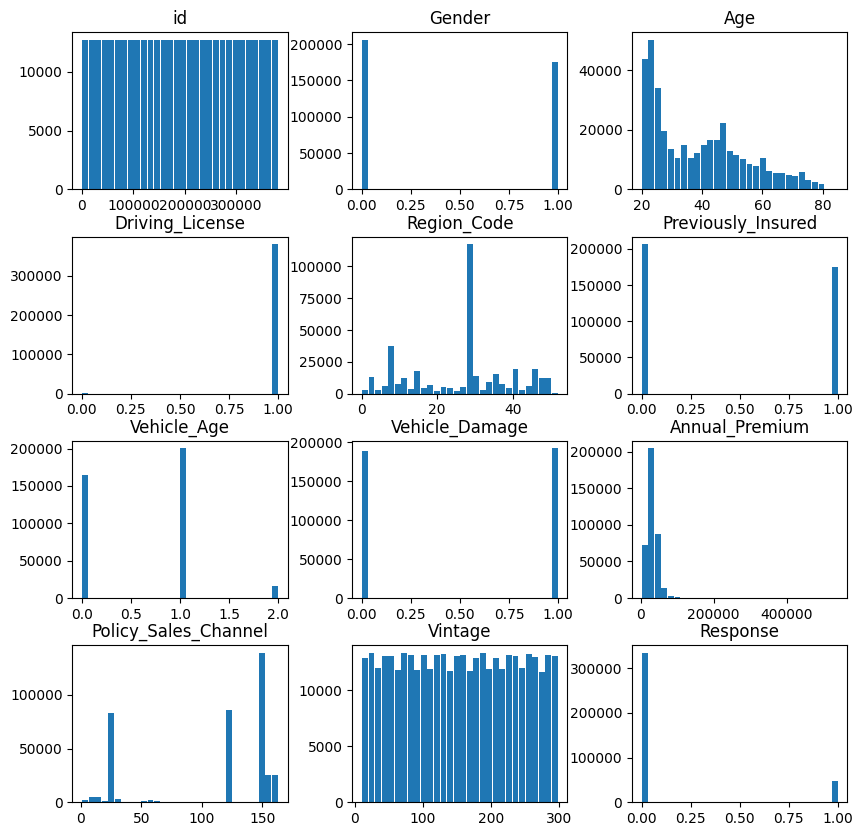

In [ ]:
# histograms for each column

df.hist(column=df.columns,
        figsize=(10,10),
        bins=30,
        rwidth=0.9,
        grid=False
             )
plt.show()

array([[<Axes: title={'center': 'Annual_Premium'}>]], dtype=object)

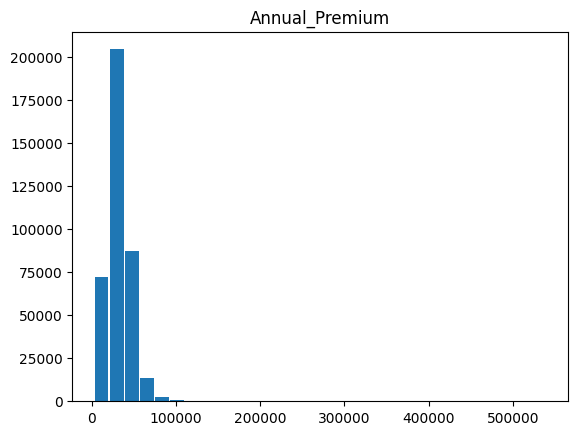

In [ ]:
# graph relating to annual_Premium seems to deserve further study

df.hist(column=['Annual_Premium'],
               bins = 30,
               rwidth=0.9,
               grid=False
              )

<Axes: >

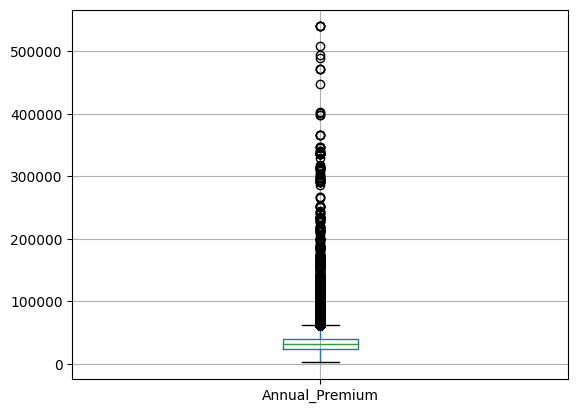

In [ ]:
df.boxplot(column='Annual_Premium')

As can be seen from the bar graph, this feature shows a clear asymmetry confirmed by the presence of some outliers found in the relevant boxplot, so it is possible to eliminate these anomalous values in order to make the training more efficient

In [ ]:
# delete all values above 90000

df_drop = df.loc[df['Annual_Premium'] < 90000]
df_drop.shape

(379774, 12)

<Axes: >

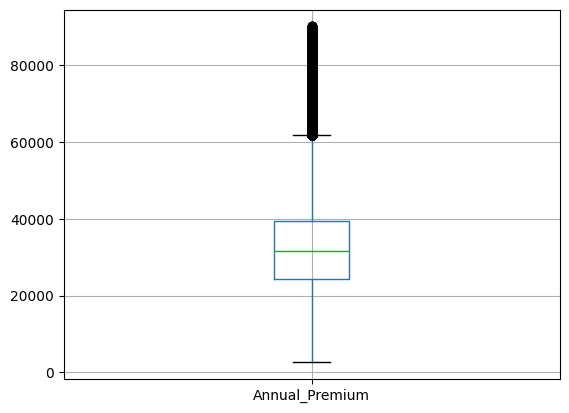

In [ ]:
df_drop.boxplot(column='Annual_Premium')

In [ ]:
#I check if the database is unbalanced with respect to some features using the Counter class by setting a for loop

colonne = ["Gender", "Driving_License", "Region_Code", "Previously_Insured", "Previously_Insured", "Vehicle_Damage", "Policy_Sales_Channel", 'Response']

for i in colonne:
  print(f"{i}: ")
  print(sorted(Counter(df[i]).items()))

Gender: 
[(0, 206089), (1, 175020)]
Driving_License: 
[(0, 812), (1, 380297)]
Region_Code: 
[(0.0, 2021), (1.0, 1008), (2.0, 4038), (3.0, 9251), (4.0, 1801), (5.0, 1279), (6.0, 6280), (7.0, 3279), (8.0, 33877), (9.0, 3101), (10.0, 4374), (11.0, 9232), (12.0, 3198), (13.0, 4036), (14.0, 4678), (15.0, 13308), (16.0, 2007), (17.0, 2617), (18.0, 5153), (19.0, 1535), (20.0, 1935), (21.0, 4266), (22.0, 1309), (23.0, 1960), (24.0, 2415), (25.0, 2503), (26.0, 2587), (27.0, 2823), (28.0, 106415), (29.0, 11065), (30.0, 12191), (31.0, 1960), (32.0, 2787), (33.0, 7654), (34.0, 1664), (35.0, 6942), (36.0, 8797), (37.0, 5501), (38.0, 2026), (39.0, 4644), (40.0, 1295), (41.0, 18263), (42.0, 591), (43.0, 2639), (44.0, 808), (45.0, 5605), (46.0, 19749), (47.0, 7436), (48.0, 4681), (49.0, 1832), (50.0, 10243), (51.0, 183), (52.0, 267)]
Previously_Insured: 
[(0, 206481), (1, 174628)]
Previously_Insured: 
[(0, 206481), (1, 174628)]
Vehicle_Damage: 
[(0, 188696), (1, 192413)]
Policy_Sales_Channel: 
[(1.0, 

The dataset is unbalanced for some features, such as Driving_Licence and the target variable Response, with a preference towards the negative class, which is why we will proceed with a resample using the RandomOverSampler class

Let's visualize the correlation matrix

<Axes: >

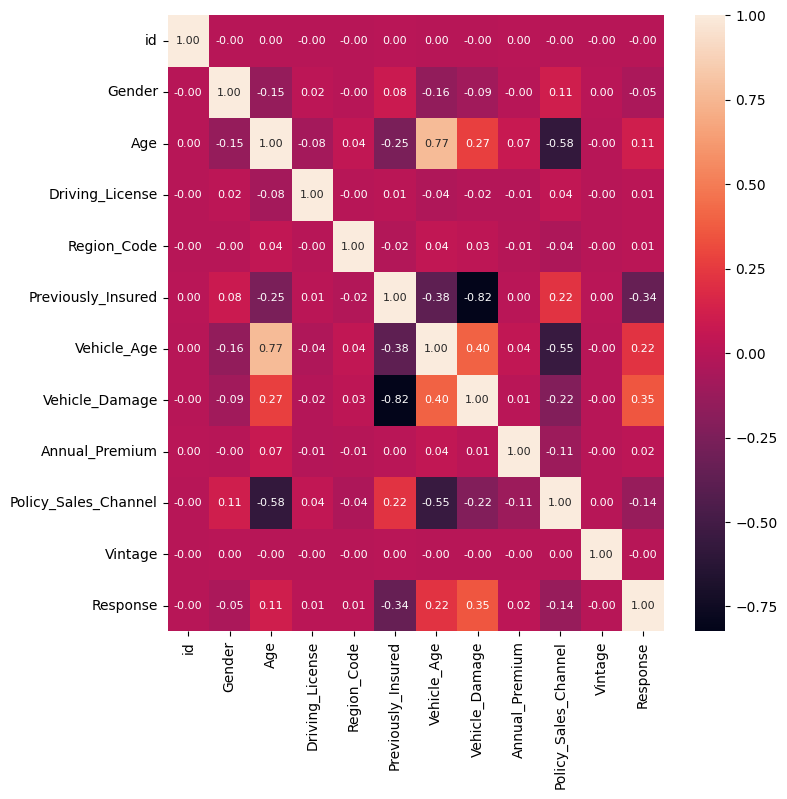

In [ ]:
plt.figure(figsize = (8,8))
sns.heatmap(df.corr(), annot=True,
            annot_kws={"size":8},
            fmt = '.2f'
            )


From the matrix we can see that some features have zero or almost zero significance, so we could also opt to eliminate the features that have a correlation in absolute value lower than a given value

In [ ]:
df_drop = df.copy()

In [ ]:
# split dataset

X = df_drop.drop(['id', 'Response'], axis=1).values
y = df_drop["Response"].values



In [ ]:
#we split the dataset into train and test, keeping 20% for the test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# Let's perform a resample with the oversampling method

ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(X_train, y_train)




In [ ]:
#standardization

scaler= StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test= scaler.transform(X_test)



# LOGISTIC REGRESSION TRAINING

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_test = lr.predict(X_test)
y_pred_train = lr.predict(X_train)



In [ ]:
print('Train Classification report:\n')
print(classification_report(y_train, y_pred_train))
print('----------------------------------------')
print('Test Classification report:\n')
print(classification_report(y_test, y_pred_test))


Train Classification report:

              precision    recall  f1-score   support

           0       0.96      0.59      0.73    267556
           1       0.71      0.97      0.82    267556

    accuracy                           0.78    535112
   macro avg       0.83      0.78      0.78    535112
weighted avg       0.83      0.78      0.78    535112

----------------------------------------
Test Classification report:

              precision    recall  f1-score   support

           0       0.99      0.59      0.74     66843
           1       0.25      0.98      0.40      9379

    accuracy                           0.64     76222
   macro avg       0.62      0.78      0.57     76222
weighted avg       0.90      0.64      0.70     76222



True Negative  : 39638
False Positive : 27205
False Negative : 217
True Positive  : 9162


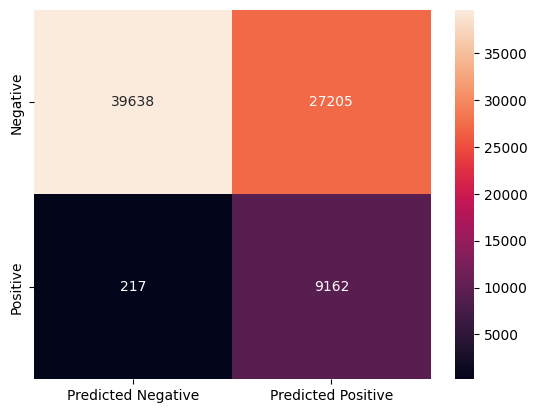

In [ ]:
# confusion matrix

plot_cm(y_test, y_pred_test)



We obtained a model that reports an accuracy of approximately 64%, the model manages to predict the negative class well, however it struggles in predicting the positive class. We could try to improve the model by tuning the hyperparameters

In [ ]:
# hyperparam grid

param_grid = [{
    'penalty': ['l1', 'l2', 'none'],
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'solver' : ['lbfgs','newton-cg','liblinear','saga'],
    'max_iter' : [100, 1000, 2500, 5000],
    'class_weight': ['balanced']
    }]

Hyperparameter tuning using Random Search preferred to GridSearchcv for execution speed

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
clf = RandomizedSearchCV(estimator=lr, param_distributions=param_grid, cv=10, n_jobs=4, return_train_score=True, random_state=1)

In [ ]:
%%time
clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solv

CPU times: user 3.08 s, sys: 585 ms, total: 3.66 s
Wall time: 2min 32s


RandomizedSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=4,
                   param_distributions=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                                         'class_weight': ['balanced'],
                                         'max_iter': [100, 1000, 2500, 5000],
                                         'penalty': ['l1', 'l2', 'none'],
                                         'solver': ['lbfgs', 'newton-cg',
                                                    'liblinear', 'saga']}],
                   random_state=1, return_train_score=True)

In [ ]:
clf.best_estimator_

LogisticRegression(C=0.0001, class_weight='balanced', max_iter=1000,
                   solver='liblinear')

In [ ]:
clf.best_score_

0.7837387281828837

In [ ]:
lr= LogisticRegression(C=1, class_weight='balanced', max_iter=2500, penalty='l1', solver='liblinear')
lr.fit(X_train, y_train)

y_pred_test = lr.predict(X_test)
y_pred_train = lr.predict(X_train)




In [ ]:
print('Accuracy after tuning\n')
print(f'Train accuracy: {accuracy_score(y_train, y_pred_train)} ')
print(f'Test accuracy: {accuracy_score(y_test, y_pred_test)} ')

Accuracy after tuning

Train accuracy: 0.7834789726262913 
Test accuracy: 0.6402351027262471 


True Negative  : 39638
False Positive : 27205
False Negative : 217
True Positive  : 9162


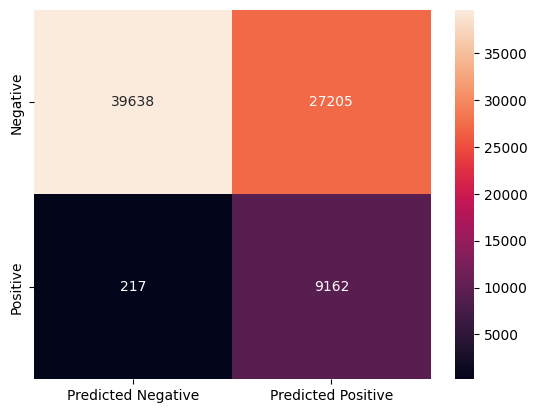

In [ ]:
plot_cm(y_test, y_pred_test)

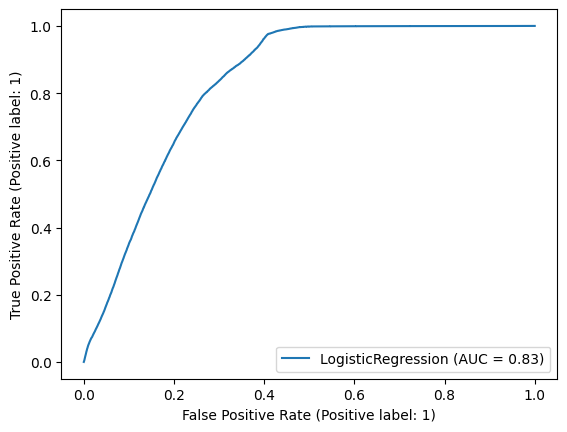

In [ ]:
RocCurveDisplay.from_estimator(lr, X_train, y_train)

#Conclusions

Using a logistic regression model, even acting on the tuning of the hyperparameters (at least the most important ones) we are unable to go beyond 64% accuracy of the model which continues to work better on the negative class than on the positive one. This tells us that there are probably other models that could better fit the data we have.